## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

## Load Dataset

In [2]:
data = pd.read_csv("/Users/ktxdev/Developer/mind-matters/data/cleaned/train.csv")
data.head()

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression,Gender_Male,...,Degree_S.Tech,Degree_UX/UI Designer,Degree_Unite,Degree_Veda,Degree_Vivaan,Degree_Vrinda,Degree_Working Professional,Working Professional or Student_Working Professional,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes
0,0.695360,5,4,NaN,5,1,1,1,0,False,...,False,False,False,False,False,False,False,True,False,False
1,-1.161867,5,3,NaN,5,2,7,2,1,True,...,False,False,False,False,False,False,False,True,True,False
2,-0.596624,4,5,0.895471,1,5,3,0,1,True,...,False,False,False,False,False,False,False,False,True,False
3,-1.484863,5,4,NaN,5,0,10,0,1,True,...,False,False,False,False,False,False,False,True,True,True
4,-0.838871,5,0,NaN,5,0,9,3,0,False,...,False,False,False,False,False,False,False,True,True,True


In [12]:
data = data[['Age', 'Working Professional or Student', 'Academic Pressure', 'City', 'Work Pressure', 'Job Satisfaction', 'Sleep Duration',
             'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 
             'Academic Pressure Applicable', 'Work Pressure Applicable', 'Job Satisfaction Applicable', 'Depression']]
data.head()

KeyError: "['Working Professional or Student', 'City', 'Sleep Duration', 'Dietary Habits', 'Have you ever had suicidal thoughts ?'] not in index"

## Feature Engineering & Feature Cleaning

In [3]:
# Standardize numerical features
data = standardize_numerical_features(data)
# Encode categorical variables
data = encode_categorical_features(data)

In [4]:
data.head()

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression,Academic Pressure Applicable,...,Degree_MBBS,Degree_MCA,Degree_MD,Degree_ME,Degree_MHM,Degree_MSc,Degree_Other,Degree_PhD,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes
0,0.695360,-0.466166,1.375429,-0.488770,-0.464194,-0.091904,-1.363057,-0.699617,0,0,...,False,False,False,False,False,False,False,False,False,False
1,-1.161867,-0.466166,0.883136,-0.488770,-0.464194,0.400871,0.193928,0.007793,1,0,...,False,False,False,False,False,False,False,False,True,False
2,-0.596624,2.938341,-1.578329,2.348688,1.315556,-1.570231,-0.844062,-1.407027,1,1,...,False,False,False,False,False,False,False,False,True,False
3,-1.484863,-0.466166,1.375429,-0.488770,-0.464194,-0.584680,0.972421,-1.407027,1,0,...,False,False,False,False,False,False,False,False,True,True
4,-0.838871,-0.466166,-0.593743,-0.488770,-0.464194,-0.584680,0.712923,0.715203,0,0,...,False,False,False,False,False,False,False,False,True,True


In [7]:
save_data(data, 'cleaned', 'train')

Dataframe saved!


## Feature Selection

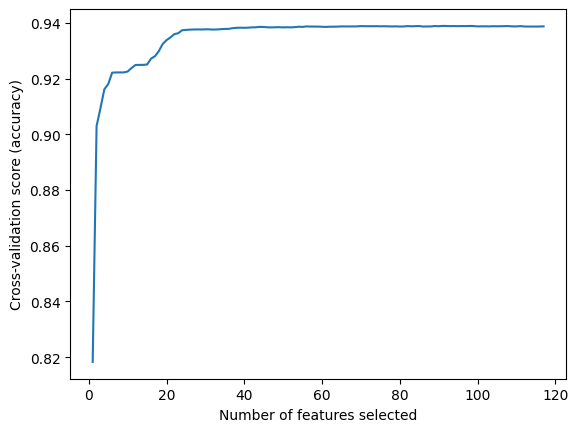

In [13]:
from sklearn.linear_model import LogisticRegression
X = data.drop(columns=['Depression'], axis=1)
y = data['Depression']

# Define the model
model = LogisticRegression(random_state=42)

# Apply RFECV
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfecv.fit(X, y)

# Plot RFECV results
cv_scores = rfecv.cv_results_['mean_test_score']

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(cv_scores) + 1), cv_scores)
plt.show()

#### Insights:
- As the number of features increases, the cross-validation accuracy improves sharply at the beginning (up to around 20 features)
- This suggests that the most important predictive features are captured within the first 20 features
- After ~20 features, the accuracy starts to plateau, indicating diminishing returns from adding more features
- Adding more features beyond this point likely introduces redundant or less informative features, which do not significantly improve the model's performance
- The "elbow point" (where the curve transitions from a sharp rise to a plateau) is a good candidate for the optimal number of features to select. This seems to be around 20-30 features in this plot
- Including all 117 features may lead to overfitting, especially if some features are irrelevant or noisy, even though the cross-validation score remains stable

In [9]:
rfecv.n_features_

np.int64(106)

In [13]:
# Fit RFE
rfe = RFE(estimator=model, n_features_to_select=20)
rfe.fit(X, y)

# Store selected features
selected_features = X.columns[rfe.support_]
data = pd.concat([X[selected_features], y.reset_index(drop=True)], axis=1).head()

/opt/homebrew/Caskroom/miniconda/base/envs/mind-matters/lib/python3.13/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=20 > n_features=18. There will be no feature selection and all features will be kept.
  warnings.warn(


In [35]:
selected_data = pd.concat([X[selected_features], y.reset_index(drop=True)], axis=1)

In [36]:
selected_data

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Academic Pressure Applicable,CGPA Applicable,...,Working Professional or Student_Working Professional,Gender_Male,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Degree_Class 12,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes,Depression
0,0.695360,-0.466166,1.375429,-0.488770,-0.464194,-0.091904,-1.363057,-0.699617,0,0,...,True,False,False,False,False,False,False,False,False,0
1,-1.161867,-0.466166,0.883136,-0.488770,-0.464194,0.400871,0.193928,0.007793,0,0,...,True,True,False,True,False,True,False,True,False,1
2,-0.596624,2.938341,-1.578329,2.348688,1.315556,-1.570231,-0.844062,-1.407027,1,1,...,False,True,False,False,False,False,False,True,False,1
3,-1.484863,-0.466166,1.375429,-0.488770,-0.464194,-0.584680,0.972421,-1.407027,0,0,...,True,True,False,True,True,False,False,True,True,1
4,-0.838871,-0.466166,-0.593743,-0.488770,-0.464194,-0.584680,0.712923,0.715203,0,0,...,True,False,False,False,False,True,False,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,-1.807859,-0.466166,1.375429,-0.488770,-0.464194,0.893647,-1.103560,0.715203,0,0,...,True,False,False,False,False,True,True,False,True,1
140696,0.049368,-0.466166,1.375429,-0.488770,-0.464194,0.893647,-0.065570,1.422613,0,0,...,True,False,True,False,True,False,False,True,True,0
140697,-1.323365,-0.466166,0.390843,-0.488770,-0.464194,-0.584680,-0.584565,0.715203,0,0,...,True,False,False,False,True,False,False,False,False,0
140698,0.695360,-0.466166,1.375429,-0.488770,-0.464194,-0.091904,0.972421,-1.407027,0,0,...,True,False,False,False,True,False,False,True,False,0


In [43]:
rfe = RFE(estimator=model, n_features_to_select=106)
rfe.fit(X, y)

# Store selected features
selected_features = X.columns[rfe.support_]

In [48]:
for s in selected_features:
    print(s,",", end = "")

Age ,Academic Pressure ,Work Pressure ,CGPA ,Study Satisfaction ,Job Satisfaction ,Work/Study Hours ,Financial Stress ,Academic Pressure Applicable ,CGPA Applicable ,Study Satisfaction Applicable ,Work Pressure Applicable ,Job Satisfaction Applicable ,City_Ahmedabad ,City_Bangalore ,City_Bhopal ,City_Chennai ,City_Delhi ,City_Faridabad ,City_Ghaziabad ,City_Hyderabad ,City_Indore ,City_Jaipur ,City_Kalyan ,City_Kanpur ,City_Kolkata ,City_Lucknow ,City_Ludhiana ,City_Meerut ,City_Mumbai ,City_Nagpur ,City_Nashik ,City_Patna ,City_Pune ,City_Rajkot ,City_Srinagar ,City_Surat ,City_Thane ,City_Vadodara ,City_Varanasi ,City_Vasai-Virar ,City_Visakhapatnam ,Working Professional or Student_Working Professional ,Profession_Architect ,Profession_Business Analyst ,Profession_Chef ,Profession_Chemist ,Profession_Civil Engineer ,Profession_Consultant ,Profession_Content Writer ,Profession_Customer Support ,Profession_Data Scientist ,Profession_Digital Marketer ,Profession_Doctor ,Profession_Educa

In [45]:
selected_data = pd.concat([X[selected_features], y.reset_index(drop=True)], axis=1)
save_data(selected_data, 'cleaned', 'train')

Dataframe saved!


In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X = data.drop(columns=['Depression'])
y = data['Depression']

# Step 2: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=3)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/mind-matters/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <F2F42313-BF4F-3B95-A853-AE1DE94D4C87> /opt/homebrew/Caskroom/miniconda/base/envs/mind-matters/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/mind-matters/lib/python3.13/lib-dynload/../../libomp.dylib' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/mind-matters/bin/../lib/libomp.dylib' (no such file)"]
